In [1]:
!nvidia-smi

Sat Nov 19 18:30:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.01    Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8    13W /  N/A |   3494MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
device = 'cuda:0'

# Read video frames:

In [3]:
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import cv2
import numpy as np
import torch

In [4]:
ref_video_path = Path('data/ref_video.mp4')
save_frames_path = Path('data/frames')
save_frames_path.mkdir(exist_ok=True, parents=True)

In [5]:
def read_video(file, n_frames=None):
    capture = cv2.VideoCapture(file)
    fps = capture.get(cv2.CAP_PROP_FPS)
    if n_frames is None:
        n_frames = capture.get(cv2.CAP_PROP_FRAME_COUNT)

    frames = []

    for _ in tqdm(np.arange(n_frames)):
        success, image_cv = capture.read()

        if not success:
            break

        frame = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
        frame = torch.tensor(frame/255, dtype=torch.float32)
        frames.append(frame.permute(2,0,1)[None])

    return frames, fps, n_frames

In [6]:
frames, fps, n_frames = read_video(str(ref_video_path), 500)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 120.89it/s]


# Preprocess data

In [7]:
import torchvision.transforms as T

In [8]:
def torch_resize(img, scale_factor):
    width = int(img.shape[3] * scale_factor)
    height = int(img.shape[2] * scale_factor)
    dim = (height, width)
    
    resize_f = T.Resize(dim)

    # resize image
    resized = resize_f(img)
    return resized

In [9]:
scale_factor = 0.5

In [10]:
timgs = []
frames2stitch_freq = 10
for i, frame in enumerate(frames):
    if i % frames2stitch_freq == 0:
        timgs.append(torch_resize(frame, scale_factor).to(device))

In [11]:
len(timgs), timgs[0].shape

(50, torch.Size([1, 3, 360, 640]))

# Stitch by kornia stitcher

In [12]:
# from kornia.contrib import ImageStitcher
# import kornia.feature as KF
# import kornia as K

# IS = ImageStitcher(KF.LoFTR(pretrained='outdoor'), estimator='ransac').to(device)

In [13]:
# out = timgs[0]
# idxs = list(range(1, len(timgs)))
# for i in tqdm(idxs):
#     try:
#         prev_out = out
#         out = IS(*[out, timgs[i]])
#     except Exception as e:
#         print(e)
#         out = prev_out

In [14]:
# import matplotlib.pyplot as plt

In [15]:
# plt.figure(figsize=(16,16))
# plt.imshow(out[0].permute(1, 2, 0).cpu())

# Custom stitching

In [16]:
from typing import Dict, List, Optional, Tuple

import torch
import torch.nn as nn

from kornia.color import rgb_to_grayscale
from kornia.feature import LocalFeatureMatcher, LoFTR
from kornia.geometry.homography import find_homography_dlt_iterated
from kornia.geometry.ransac import RANSAC
from kornia.geometry.transform import warp_perspective

import kornia.feature as KF
import matplotlib.pyplot as plt

In [17]:
matcher = KF.LoFTR(pretrained='outdoor').to(device)
estimator = 'ransac'
blending_method = 'naive'
ransac = RANSAC('homography').to(device)

In [18]:
def estimate_homography(keypoints1: torch.Tensor, keypoints2: torch.Tensor) -> torch.Tensor:
    """Estimate homography by the matched keypoints.

    Args:
        keypoints1: matched keypoint set from an image, shaped as :math:`(N, 2)`.
        keypoints2: matched keypoint set from the other image, shaped as :math:`(N, 2)`.
    """
    homo, _ = ransac(keypoints2, keypoints1)
    homo = homo[None]
    return homo

def estimate_transform(**kwargs) -> torch.Tensor:
    """Compute the corresponding homography."""
    homos: List[torch.Tensor] = []
    kp1, kp2, idx = kwargs['keypoints0'], kwargs['keypoints1'], kwargs['batch_indexes']
    for i in range(len(idx.unique())):
        homos.append(estimate_homography(kp1[idx == i], kp2[idx == i]))
    if len(homos) == 0:
        raise RuntimeError("Compute homography failed. No matched keypoints found.")
    return torch.cat(homos)

def blend_image(src_img: torch.Tensor, dst_img: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """Blend two images together."""
    out: torch.Tensor
    out = torch.where(mask == 1, src_img, dst_img)
    return out

def preprocess(image_1: torch.Tensor, image_2: torch.Tensor) -> Dict[str, torch.Tensor]:
    """Preprocess input to the required format."""
    if isinstance(matcher, LoFTR) or isinstance(matcher, LocalFeatureMatcher):
        input_dict: Dict[str, torch.Tensor] = {  # LofTR works on grayscale images only
            "image0": rgb_to_grayscale(image_1),
            "image1": rgb_to_grayscale(image_2),
        }
    else:
        raise NotImplementedError(f"The preprocessor for {matcher} has not been implemented.")
    return input_dict

def postprocess(image: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    # NOTE: assumes no batch mode. This method keeps all valid regions after stitching.
    mask_: torch.Tensor = mask.sum((0, 1))
    index: int = int(mask_.bool().any(0).long().argmin().item())
    if index == 0:  # If no redundant space
        return image
    return image[..., :index]

def on_matcher(data) -> dict:
    return matcher(data)

def stitch_pair(
    images_left: torch.Tensor,
    images_right: torch.Tensor,
    mask_left: Optional[torch.Tensor] = None,
    mask_right: Optional[torch.Tensor] = None,
) -> Tuple[torch.Tensor, torch.Tensor]:
    # Compute the transformed images
    input_dict: Dict[str, torch.Tensor] = preprocess(images_left, images_right)
    out_shape: Tuple[int, int] = (images_left.shape[-2], images_left.shape[-1] + images_right.shape[-1])
    correspondences: dict = on_matcher(input_dict)
    homo: torch.Tensor = estimate_transform(**correspondences)
    src_img = warp_perspective(images_right, homo, out_shape)
    dst_img = torch.cat([images_left, torch.zeros_like(images_right)], dim=-1)

    # Compute the transformed masks
    if mask_left is None:
        mask_left = torch.ones_like(images_left)
    if mask_right is None:
        mask_right = torch.ones_like(images_right)
    # 'nearest' to ensure no floating points in the mask
    src_mask = warp_perspective(mask_right, homo, out_shape, mode='nearest')
    dst_mask = torch.cat([mask_left, torch.zeros_like(mask_right)], dim=-1)
    return blend_image(src_img, dst_img, src_mask), (dst_mask + src_mask).bool().to(src_mask.dtype)

In [19]:
with torch.inference_mode():
    img_out = timgs[0]
    mask_left = torch.ones_like(img_out).to(device)
    for i in tqdm(list(range(len(timgs) - 1))):
        img_out, _mask_left = stitch_pair(img_out, timgs[i + 1], mask_left)
        img_out = postprocess(img_out, _mask_left)    

  0%|                                                                                            | 0/49 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/kornia/feature/loftr/utils/coarse_matching.py:243: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  mkpts0_c = torch.stack([i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]], dim=1) * scale0
/opt/conda/lib/python3.8/site-packages/kornia/feature/loftr/utils/coarse_matching.py:244: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. 

In [21]:
img_out.shape

torch.Size([1, 3, 360, 640])

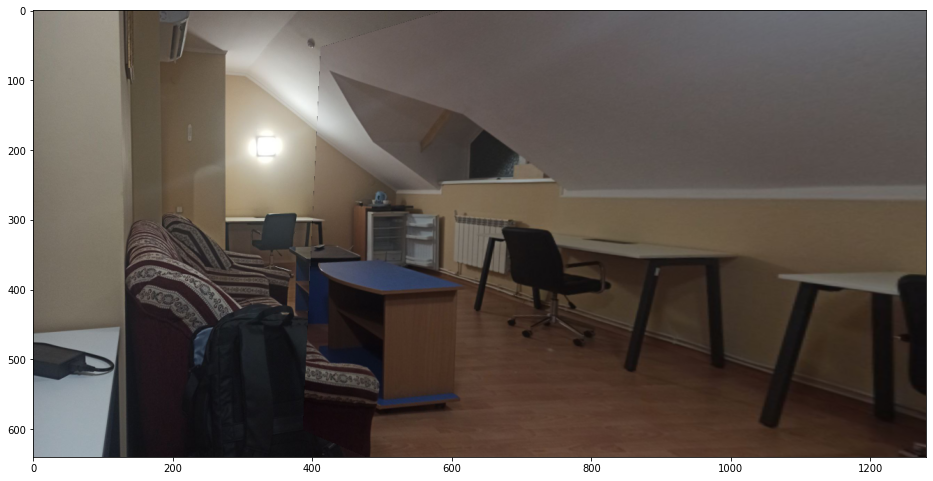

In [21]:
plt.figure(figsize=(16,16))
plt.imshow(img_out[0].permute(1, 2, 0).cpu())